In [1]:
##################################################
# 不要修改此单元格中的代码
##################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

def count_parameters(model):
    total = sum([param.nelement() for param in model.parameters()])
    print("Number of parameter: %.2fM" % (total / 1e6))
    return total


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch(net, train_iter, loss_fn, optimizer):
    net.train()
    device = next(net.parameters()).device
    metrics = Accumulator(4)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
        train_loss = metrics[0] / metrics[2]
        train_acc = metrics[1] / metrics[2]
    return train_loss, train_acc


@torch.no_grad()
def eval_model(net, test_iter, loss_fn):
    net.eval()
    device = next(net.parameters()).device
    metrics = Accumulator(3)
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
    test_loss = metrics[0] / metrics[2]
    test_acc = metrics[1] / metrics[2]
    return test_loss, test_acc


def accuracy(y_hat, y_true):
    y_pred = y_hat.argmax(dim=1)
    return (y_pred == y_true).float().mean().item()


logging_columns_list = ["epoch", "train_loss", "test_loss", "train_acc", "test_acc"]


def print_columns(columns_list=logging_columns_list, is_head=False, is_final_entry=False):
    print_string = ""
    for col in columns_list:
        print_string += "|  %s  " % col
    print_string += "|"
    if is_head:
        print("-" * len(print_string))
    print(print_string)
    if is_head or is_final_entry:
        print("-" * len(print_string))


def print_training_details(variables, is_final_entry):
    formatted = []
    for col in logging_columns_list:
        var = variables.get(col.strip(), None)
        if type(var) in (int, str):
            res = str(var)
        elif type(var) is float:
            res = "{:0.4f}".format(var)
        else:
            assert var is None
            res = ""
        formatted.append(res.rjust(len(col)))
    print_columns(formatted, is_final_entry=is_final_entry)

In [2]:
import torchvision.transforms as T


def load_data(root="cifar10", batch_size=64):
    MEAN = (0.4914, 0.4822, 0.4465)
    STD = (0.2023, 0.1994, 0.2010)
    train_trans = T.Compose(
        [
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(MEAN, STD),
        ]
    )
    test_trans = T.Compose([T.ToTensor(), T.Normalize(MEAN, STD)])

    train_data = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=train_trans)
    test_data = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=test_trans)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader

In [3]:
##################################################
# 在此填入你设计的网络模型, 并展示模型参数量
##################################################


class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.norm1 = nn.BatchNorm2d(channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(channels_out)
        self.activ = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.norm1(x)
        x = self.activ(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        return x


class FastNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=2, padding=0, bias=True)
        self.conv_groups = nn.ModuleList(
            [
                ConvGroup(12, 64),
                ConvGroup(64, 256),
                ConvGroup(256, 256),
            ]
        )
        self.pool = nn.MaxPool2d(3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(256, 10)

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        for conv_group in self.conv_groups:
            x = conv_group(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x


model_test = FastNet()
count_parameters(model_test)

x_test = torch.randn(20, 3, 32, 32)
y_test = model_test(x_test)
assert y_test.shape == torch.Size([20, 10]), f"Expected output shape: [20, 10], but got {y_test.shape}"

Number of parameter: 1.97M


In [4]:
from tqdm import tqdm


def train_cifar(config):
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    momentum = config["momentum"]

    train_loader, test_loader = load_data("cifar10", batch_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastNet().to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=config["max_lr"],
        pct_start=config["pct_start"],
        epochs=epochs,
        steps_per_epoch=1,
    )
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
        scheduler.step()
        test_loss, test_acc = eval_model(model, test_loader, loss_fn)
        if test_acc > best_acc:
            best_acc = test_acc
    return best_acc

In [5]:
import optuna


def objective(trial):
    config = {
        "batch_size": 1024,
        "epochs": 20,
        "lr": trial.suggest_float("lr", 1e-3, 0.1, log=True),
        "momentum": trial.suggest_float("momentum", 0.8, 0.9),
        "max_lr": trial.suggest_float("max_lr", 0.5, 1.0),
        "pct_start": trial.suggest_float("pct_start", 0.1, 0.9),
    }
    # 目标函数为测试集准确率
    test_acc = train_cifar(config)
    return test_acc


study = optuna.create_study(direction="maximize")  # 最大化准确率
study.optimize(objective, n_trials=10)  # 运行 10 次试验

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

results_df = study.trials_dataframe()
results_df.to_csv("FastNet.csv", index=False)

[I 2024-05-13 04:59:13,166] A new study created in memory with name: no-name-3d12e447-3d3d-4060-8c10-6673db7597f1
100%|██████████| 20/20 [01:39<00:00,  4.98s/it]
[I 2024-05-13 05:00:53,435] Trial 0 finished with value: 0.9007999990463257 and parameters: {'lr': 0.07370733714402043, 'momentum': 0.8671448858793199, 'max_lr': 0.9319213220370028, 'pct_start': 0.4543061889539819}. Best is trial 0 with value: 0.9007999990463257.
100%|██████████| 20/20 [01:38<00:00,  4.91s/it]
[I 2024-05-13 05:02:32,288] Trial 1 finished with value: 0.7848999966621399 and parameters: {'lr': 0.04271083008533259, 'momentum': 0.825337357504949, 'max_lr': 0.70115155680053, 'pct_start': 0.13227046232142722}. Best is trial 0 with value: 0.9007999990463257.
100%|██████████| 20/20 [01:38<00:00,  4.92s/it]
[I 2024-05-13 05:04:11,240] Trial 2 finished with value: 0.7960999967575073 and parameters: {'lr': 0.020032223006664455, 'momentum': 0.8491448733221948, 'max_lr': 0.6532688884993663, 'pct_start': 0.11374385138093422}

Best trial:
  Value:  0.9104999983787536
  Params: 
    lr: 0.003907495040617713
    momentum: 0.8251348067763132
    max_lr: 0.7093774347806429
    pct_start: 0.7281514602597384


In [6]:
import pandas as pd

results_df = pd.read_csv("FastNet.csv")
results_df = results_df.sort_values(by="value", ascending=False)
results_df.head(5)

,number,value,datetime_start,datetime_complete,duration,params_lr,params_max_lr,params_momentum,params_pct_start,state
8,8,0.9105,2024-05-13 05:13:19.833574,2024-05-13 05:15:03.390455,0 days 00:01:43.556881,0.003907,0.709377,0.825135,0.728151,COMPLETE
5,5,0.9103,2024-05-13 05:07:29.055723,2024-05-13 05:09:36.835813,0 days 00:02:07.780090,0.018123,0.769726,0.872457,0.569675,COMPLETE
7,7,0.9085,2024-05-13 05:11:24.294504,2024-05-13 05:13:19.833070,0 days 00:01:55.538566,0.010736,0.666611,0.809495,0.727439,COMPLETE
3,3,0.9036,2024-05-13 05:04:11.240631,2024-05-13 05:05:50.252651,0 days 00:01:39.012020,0.001296,0.780598,0.800981,0.424323,COMPLETE
6,6,0.9023,2024-05-13 05:09:36.836347,2024-05-13 05:11:24.294022,0 days 00:01:47.457675,0.016807,0.962740,0.855604,0.485985,COMPLETE


In [7]:
opt_cfg = results_df.iloc[0].to_dict()
epochs = 20
batch_size = 1024
lr = opt_cfg["params_lr"]
momentum = opt_cfg["params_momentum"]


train_loader, test_loader = load_data("cifar10", batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=opt_cfg["params_max_lr"],
    pct_start=opt_cfg["params_pct_start"],
    epochs=epochs,
    steps_per_epoch=1,
)
loss_fn = nn.CrossEntropyLoss()

train_ls, test_ls, train_acc_ls, test_acc_ls = [], [], [], []
print_columns(is_head=True)
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    scheduler.step()
    test_loss, test_acc = eval_model(model, test_loader, loss_fn)
    print_training_details(locals(), is_final_entry=True if epoch == epochs else False)
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)

-------------------------------------------------------------------
|  epoch  |  train_loss  |  test_loss  |  train_acc  |  test_acc  |
-------------------------------------------------------------------
|      1  |      1.7432  |     1.3818  |     0.3741  |    0.4922  |
|      2  |      1.1437  |     1.0249  |     0.5874  |    0.6392  |
|      3  |      0.8524  |     0.8299  |     0.6995  |    0.7151  |
|      4  |      0.7182  |     0.6454  |     0.7531  |    0.7786  |
|      5  |      0.5524  |     0.6735  |     0.8077  |    0.7807  |
|      6  |      0.5211  |     0.6805  |     0.8209  |    0.7907  |
|      7  |      0.4229  |     0.5125  |     0.8536  |    0.8367  |
|      8  |      0.3810  |     0.5641  |     0.8669  |    0.8165  |
|      9  |      0.3844  |     0.4447  |     0.8704  |    0.8547  |
|     10  |      0.3067  |     0.4973  |     0.8942  |    0.8432  |
|     11  |      0.2819  |     0.4480  |     0.9028  |    0.8515  |
|     12  |      0.2504  |     0.4670  |     0.9

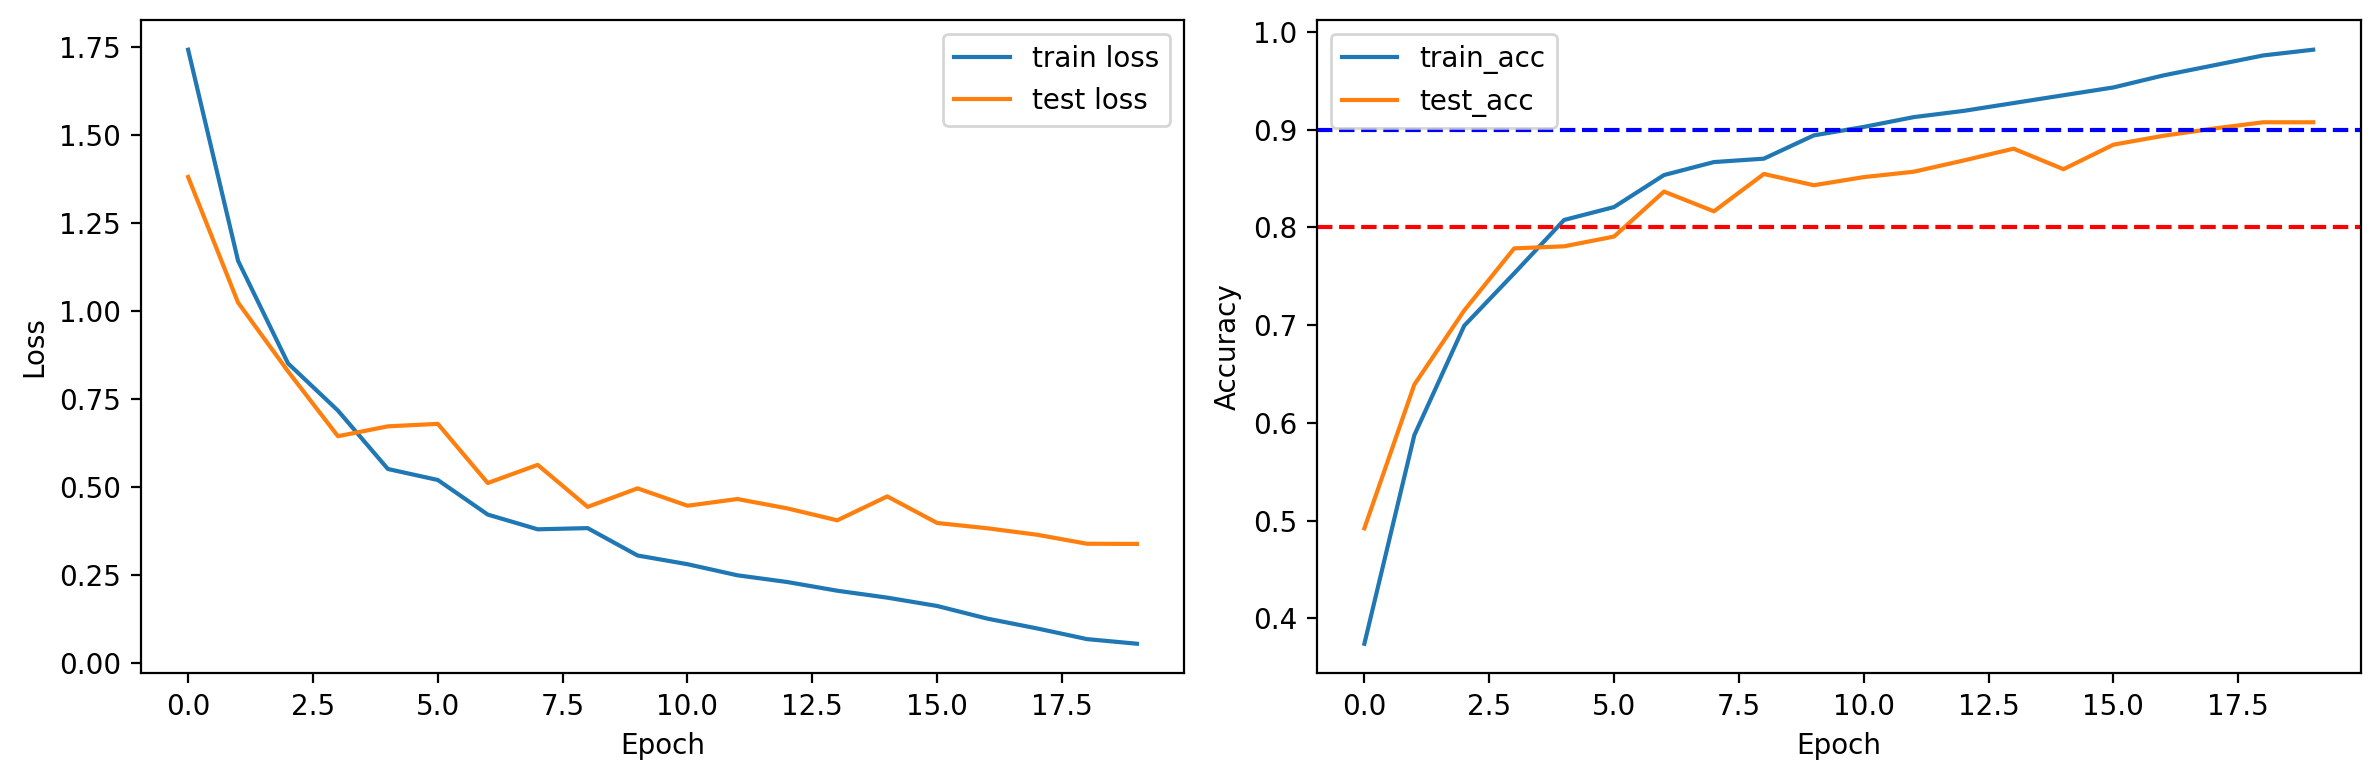

Best test accuaracy:  0.9076000008583068


In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 绘制第一个子图
axs[0].plot(train_ls, label="train loss")
axs[0].plot(test_ls, label="test loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# 绘制第二个子图
axs[1].plot(train_acc_ls, label="train_acc")
axs[1].plot(test_acc_ls, label="test_acc")
axs[1].axhline(y=0.8, color='r', linestyle='--')  # 添加 y=0.8 的参考线
axs[1].axhline(y=0.9, color='b', linestyle='--')  # 添加 y=0.9 的参考线
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()
print("Best test accuaracy: ", max(test_acc_ls))